In [2]:
import os
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pickle import dump
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
os.getcwd()

'/workspaces/mds8-final-project-bmh/EDA'

In [4]:
# Loading data from SQLite to pandas

path_to_db = '/workspaces/mds8-final-project-bmh/data/raw/rentcast_FL.db'
conn = sqlite3.connect(path_to_db)
query = """SELECT * FROM properties"""
data = pd.read_sql(query, conn)
conn.close()
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,foundationType,garage,garageSpaces,garageType,pool,roomCount,unitCount,viewType
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,...,0,2.0,None,0,NaN,None,True,NaN,1.0,Water
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3.0,...,0,1.0,None,1,4.0,Garage,False,NaN,1.0,None
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None


In [5]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [6]:
# Creating a column for years old

data = data[data['yearBuilt'] <= 2025]

data['years_old'] = 2025 - data['yearBuilt']

In [7]:
# Changing the multiple ways to designate pool into 1/0

bool_mapper = {
    '1':1,
    '0':0,
    'True':1,
    'False':0,
    'Inground':1,
    'Type Unknown': 1,
    'Pool/spa':1
}

data['pool'] = data['pool'].map(bool_mapper).fillna(0).astype(int)

In [8]:
# Creating column with average interest rates from FRED

data.lastSaleDate = pd.to_datetime(data.lastSaleDate)

data['year_month'] = data['lastSaleDate'].dt.to_period('M')

t_rate = {
    '2024-03':0.0421,
    '2024-04':0.0454,
    '2024-05':0.0448,
    '2024-06':0.0431,
    '2024-07':0.0425,
    '2024-08':0.0387,
    '2024-09':0.0372,
    '2024-10':0.041,
    '2024-11':0.0436,
    '2024-12':0.0439,
    '2025-01':0.0463,
    '2025-02':0.0445,
    '2025-03':0.0668
}

data['year_month'] = data['year_month'].dt.strftime('%Y-%m')

data['t_rate'] = data['year_month'].map(t_rate)

/tmp/ipykernel_844/3976603651.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['lastSaleDate'].dt.to_period('M')


In [ ]:
# Dropping columns

cols = [
    # 'id',
    'formattedAddress',
    'city',
    # 'state',
    'zipCode',
    'county',
    'latitude',
    'longitude',
    'propertyType',
    'bedrooms',
    'bathrooms',
    'squareFootage',
    'lotSize',
    'yearBuilt',
    # 'subdivision',
    # 'zoning',
    # 'lastSaleDate',
    'lastSalePrice',
    # 'hoa',
    # 'architectureType',
    'cooling',
    # 'coolingType',
    'heating',
    # 'heatingType',
    # 'exteriorType',
    'fireplace',
    'floorCount',
    # 'foundationType',
    'garage',
    'garageSpaces',
    # 'garageType',
    'pool',
    # 'roomCount',
    # 'unitCount',
    # 'viewType',
    'years_old',
    't_rate',
    ]

In [10]:
data = data[cols]
data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1,"5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,33705,Pinellas,27.72,-82.63,Townhouse,2.00,1.50,"1,022.00",...,"469,000.00",0,0,0,2.00,0,NaN,1,46.00,0.04
2,"1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,32254,Duval,30.34,-81.72,Single Family,3.00,1.00,"1,192.00",...,"170,000.00",1,1,0,1.00,1,4.00,0,74.00,0.04
3,"2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,33019,Broward,26.00,-80.12,Condo,2.00,2.00,865.00,...,"300,000.00",0,0,0,NaN,0,NaN,0,60.00,0.04
4,"6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,33472,Palm Beach,26.56,-80.14,Condo,2.00,2.00,"1,335.00",...,"250,000.00",0,0,0,NaN,0,NaN,0,39.00,0.04
5,"8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,33473,Palm Beach,26.49,-80.18,Single Family,3.00,2.50,"2,338.00",...,"765,000.00",1,1,0,1.00,1,NaN,1,11.00,0.04


In [11]:
data['cooling'].isna().any()

np.False_

In [12]:
data['propertyType'].unique()

array(['Townhouse', 'Single Family', 'Condo', 'Multi-Family', 'Land',
       'Manufactured', 'Apartment', None], dtype=object)

In [ ]:
# Filtering for property type

prop_types = [
    'Single Family', 
    'Townhouse', 
    'Condo', 
    # 'Multi-Family', 
    # 'Land',
    'Manufactured', 
    # 'Apartment',
]

In [14]:
data = data[data['propertyType'].isin(prop_types)]

In [15]:
data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1,"5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,33705,Pinellas,27.72,-82.63,Townhouse,2.00,1.50,"1,022.00",...,"469,000.00",0,0,0,2.00,0,NaN,1,46.00,0.04
2,"1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,32254,Duval,30.34,-81.72,Single Family,3.00,1.00,"1,192.00",...,"170,000.00",1,1,0,1.00,1,4.00,0,74.00,0.04
3,"2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,33019,Broward,26.00,-80.12,Condo,2.00,2.00,865.00,...,"300,000.00",0,0,0,NaN,0,NaN,0,60.00,0.04
4,"6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,33472,Palm Beach,26.56,-80.14,Condo,2.00,2.00,"1,335.00",...,"250,000.00",0,0,0,NaN,0,NaN,0,39.00,0.04
5,"8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,33473,Palm Beach,26.49,-80.18,Single Family,3.00,2.50,"2,338.00",...,"765,000.00",1,1,0,1.00,1,NaN,1,11.00,0.04


In [16]:
data.shape

(119951, 22)

In [17]:
# Filling nulls in lotSize for Condos with 0

data.loc[(data['propertyType'] == 'Condo'), 'lotSize'] = 0 #& (data['lotSize'].isnull())

In [18]:
# Filling nulls in floor count with 1

data['floorCount'] = data['floorCount'].fillna(1)

In [19]:
# Filling nulls in garageSpaces with 1

data['garageSpaces'] = data['garageSpaces'].fillna(1)

In [20]:
data = data.dropna()
data.shape

(114713, 22)

In [21]:
data['lastSalePrice'].describe()

count       114,713.00
mean        547,848.65
std       1,851,406.24
min             310.00
25%         255,000.00
50%         369,900.00
75%         545,000.00
max     345,000,000.00
Name: lastSalePrice, dtype: float64

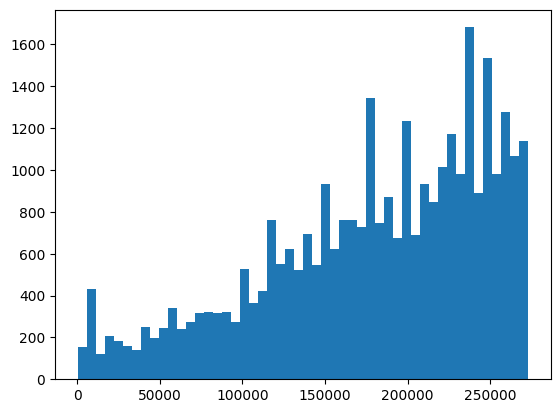

In [ ]:
# Determining price range to feed to model

low_price = data[data['lastSalePrice'] < 273000]

plt.hist(low_price['lastSalePrice'], bins=50)
plt.show()

In [23]:
very_low = data[data['lastSalePrice'] < 50000]
very_low.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1856 entries, 17 to 145570
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  1856 non-null   object 
 1   city              1856 non-null   object 
 2   zipCode           1856 non-null   int64  
 3   county            1856 non-null   object 
 4   latitude          1856 non-null   float64
 5   longitude         1856 non-null   float64
 6   propertyType      1856 non-null   object 
 7   bedrooms          1856 non-null   float64
 8   bathrooms         1856 non-null   float64
 9   squareFootage     1856 non-null   float64
 10  lotSize           1856 non-null   float64
 11  yearBuilt         1856 non-null   float64
 12  lastSalePrice     1856 non-null   float64
 13  cooling           1856 non-null   int64  
 14  heating           1856 non-null   int64  
 15  fireplace         1856 non-null   int64  
 16  floorCount        1856 non-null   float64
 1

In [24]:
very_low.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
count,"1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00","1,856.00"
mean,"33,694.05",28.39,-82.10,2.92,1.92,"1,484.11","14,678.24","1,998.53","24,004.44",0.50,0.53,0.08,1.03,0.40,1.08,0.05,26.47,0.04
std,847.34,1.30,1.25,0.80,0.56,539.08,"39,684.39",27.69,"14,349.53",0.50,0.50,0.27,0.18,0.49,0.32,0.21,27.69,0.00
min,"32,008.00",25.09,-87.43,1.00,0.50,200.00,0.00,"1,891.00",310.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.04
25%,"32,909.00",26.99,-82.27,2.00,2.00,"1,136.00","6,970.00","1,978.00","10,000.00",0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.04
50%,"33,955.50",28.87,-82.01,3.00,2.00,"1,456.00","10,019.00","2,004.00","22,600.00",1.00,1.00,0.00,1.00,0.00,1.00,0.00,21.00,0.04
75%,"34,470.00",29.15,-81.63,3.00,2.00,"1,810.00","12,632.00","2,024.00","38,000.00",1.00,1.00,0.00,1.00,1.00,1.00,0.00,47.00,0.05
max,"34,997.00",30.97,-80.05,6.00,6.00,"6,009.00","871,200.00","2,025.00","49,900.00",1.00,1.00,1.00,3.00,1.00,6.00,1.00,134.00,0.05


In [25]:
very_low[very_low['bedrooms'] == 6]

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1463,"1115 Joseph St, Jacksonville, FL 32206",Jacksonville,32206,Duval,30.35,-81.64,Single Family,6.00,2.00,"1,474.00",...,"48,900.00",1,1,0,2.00,0,1.00,0,111.00,0.04
91479,"1045 E 24th St, Jacksonville, FL 32206",Jacksonville,32206,Duval,30.36,-81.64,Single Family,6.00,3.50,"1,723.00",...,"45,000.00",1,1,1,1.00,0,1.00,0,97.00,0.04
124552,"2223 Carver Ave, Fort Myers, FL 33916",Fort Myers,33916,Lee,26.64,-81.85,Single Family,6.00,5.00,"1,832.00",...,"47,000.00",0,0,0,1.00,0,1.00,0,1.00,0.04
124559,"2219 Carver Ave, Fort Myers, FL 33916",Fort Myers,33916,Lee,26.64,-81.85,Single Family,6.00,5.00,"2,000.00",...,"47,000.00",0,0,0,1.00,0,1.00,0,1.00,0.04


These are either inaccurate or very old without renovations. May need to filter for both year built and price range.

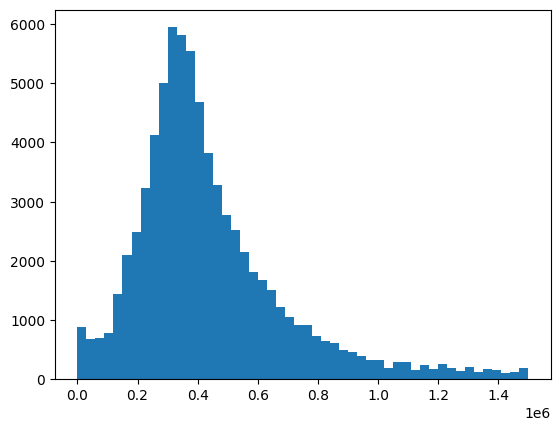

In [26]:
newer = data[data['yearBuilt'] >= 1980]

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 1_500_000))
plt.show()

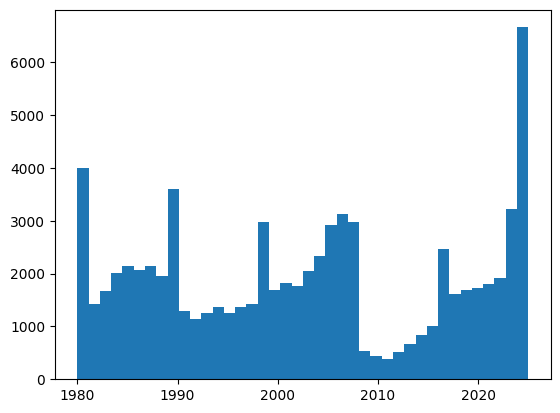

In [27]:
plt.hist(newer['yearBuilt'], bins=40)
plt.show()

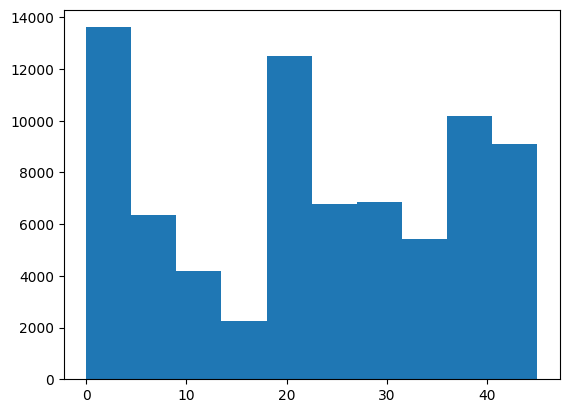

In [28]:
plt.hist(newer['years_old'])
plt.show()

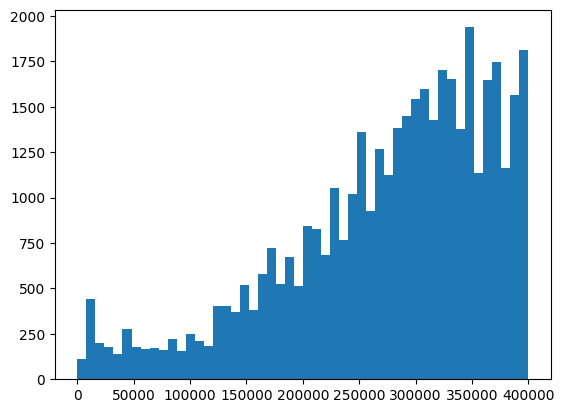

In [29]:
# Zooming in on that lower dip

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 400000))
plt.show()

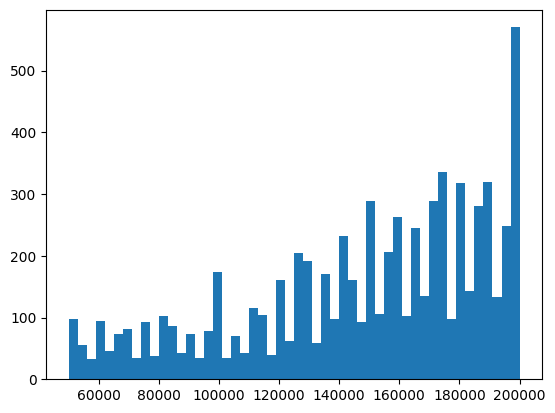

In [30]:
plt.hist(newer['lastSalePrice'], bins=50, range=(50000, 200000))
plt.show()

In [31]:
# filtering by price

filtered = newer[(newer['lastSalePrice'] > 100_000) & ((newer['lastSalePrice'] < 1_000_000))]

In [32]:
filtered.shape

(68224, 22)

In [33]:
filtered['county'].value_counts().head(15)

county
Palm Beach      4739
Lee             4693
Hillsborough    4460
Orange          3682
Polk            3562
Broward         3462
Miami-Dade      3454
Duval           3049
Pasco           2875
Osceola         2271
Marion          2217
Volusia         2183
Brevard         2043
Manatee         2041
Sarasota        1985
Name: count, dtype: int64

In [34]:
county_counts = filtered['county'].value_counts()
big_counties= county_counts[county_counts >= 2216].index

filtered = filtered[filtered['county'].isin(big_counties)]

filtered.shape

(38464, 22)

In [35]:
filtered.columns.tolist()

['formattedAddress',
 'city',
 'zipCode',
 'county',
 'latitude',
 'longitude',
 'propertyType',
 'bedrooms',
 'bathrooms',
 'squareFootage',
 'lotSize',
 'yearBuilt',
 'lastSalePrice',
 'cooling',
 'heating',
 'fireplace',
 'floorCount',
 'garage',
 'garageSpaces',
 'pool',
 'years_old',
 't_rate']

In [ ]:
# Saving cleaned data

conn = sqlite3.connect('/workspaces/mds8-final-project-bmh/data/processed/cleaned_model_data.db')

conn.execute(""" CREATE TABLE IF NOT EXISTS properties (
             
formattedAddress    TEXT    PRIMARY KEY,
city                TEXT,
zipCode             TEXT,
county              TEXT,
latitude            DECIMAL,
longitude           DECIMAL,
propertyType        TEXT,
bedrooms            INTEGER,
bathrooms           INTEGER,
squareFootage       INTEGER,
lotSize             INTEGER,
yearBuilt           INTEGER,
lastSalePrice       INTEGER,
cooling             TEXT,
heating             TEXT,
fireplace           TEXT,
floorCount          INTEGER,
garage              TEXT,
garageSpaces        INTEGER,
pool                TEXT,
years_old           INTEGER
t_rate              decimal
);            
"""
)

data.to_sql('properties', conn, if_exists='replace', index=False)

conn.close()

In [35]:
filtered = filtered.copy()
filtered['zipCode'] = filtered['zipCode'].astype(str)

In [36]:
num_var = [
    'latitude',
    'longitude',
    'bedrooms',
    'bathrooms',
    'squareFootage',
    'lotSize',
    # 'yearBuilt',
    # 'subdivision',
    # 'zoning',
    # 'lastSaleDate',
    'floorCount',
    'lastSalePrice',
    'years_old',
    'pool',
    'cooling',
    'heating',
    'fireplace',
    'garage',
    'garageSpaces',
    't_rate',
]

cat_var = [
    'city',
    'zipCode',
    'county',
    'propertyType',
]

In [37]:
# Getting dummies for cat_var

cat_data = pd.get_dummies(filtered[cat_var])

# Recreating the dataframe with the numerical and dummy columns 

model_data = pd.concat([filtered[num_var], cat_data], axis=1)

In [38]:
# Features and target, splitting data

y = model_data['lastSalePrice']
X = model_data.drop(['lastSalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [39]:
# For app

model_columns = X.columns.tolist()
dump(model_columns, open('/workspaces/mds8-final-project-bmh/src/model_columns.sav', 'wb'))

model_cities = filtered['city'].unique().tolist()
model_cities.sort()
dump(model_cities, open('/workspaces/mds8-final-project-bmh/src/model_cities.sav', 'wb'))

In [40]:
filtered['garageSpaces'].unique()

array([ 1.,  2.,  4.,  3.,  5.,  6.,  8., 11.,  9.])

In [41]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38464 entries, 4 to 145612
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  38464 non-null  object 
 1   city              38464 non-null  object 
 2   zipCode           38464 non-null  object 
 3   county            38464 non-null  object 
 4   latitude          38464 non-null  float64
 5   longitude         38464 non-null  float64
 6   propertyType      38464 non-null  object 
 7   bedrooms          38464 non-null  float64
 8   bathrooms         38464 non-null  float64
 9   squareFootage     38464 non-null  float64
 10  lotSize           38464 non-null  float64
 11  yearBuilt         38464 non-null  float64
 12  lastSalePrice     38464 non-null  float64
 13  cooling           38464 non-null  int64  
 14  heating           38464 non-null  int64  
 15  fireplace         38464 non-null  int64  
 16  floorCount        38464 non-null  float64
 1

In [42]:
zip_county_dict = dict(zip(filtered['zipCode'], filtered['county']))
dump(zip_county_dict, open('/workspaces/mds8-final-project-bmh/src/zip_county_dict.sav', 'wb'))

In [43]:
city_zip_dict = filtered.groupby('city')['zipCode'].unique().apply(list).to_dict()
dump(city_zip_dict, open('/workspaces/mds8-final-project-bmh/src/city_zip_dict.sav', 'wb'))

In [44]:
x_test_idx = X_test.index

In [45]:
X_train.shape

(30771, 650)

In [46]:
colsample_bytree=0.8, 
learning_rate=0.1, 
max_depth=8, 
n_estimators=200, 
reg_alpha=0, 
reg_lambda=1.5, 
subsample=0.8

In [47]:
# XGBoost Regressor

xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 83588.90497043726
Coefficient of determination: 0.7947923946308426


In [48]:
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    colsample_bytree=0.8, 
    learning_rate=0.1, 
    max_depth=8, 
    n_estimators=200, 
    reg_alpha=0, 
    reg_lambda=1.5, 
    subsample=0.8)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 81031.57889808918
Coefficient of determination: 0.8071565985987184


In [49]:
dump(xgb_model, open('../models/matt_xgbr_opt.sav', 'wb'))

In [50]:
param_grid = {
    'max_depth': [8, 10, 12], # check the depth 
    'learning_rate': np.logspace(0.01, 0.1, 3), 
    'subsample': [0.5, 0.8, 1.0],
    'reg_alpha': np.logspace(0, 0.1, 3),
    'reg_lambda': np.linspace(1, 2, 3)
}

# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     cv=3,
#     verbose=2,
# )

# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

In [51]:
# # From GridSearch on local
# {'learning_rate': np.float64(1.023292992280754), 'max_depth': 8, 'reg_alpha': np.float64(1.1220184543019633), 'reg_lambda': np.float64(2.0), 'subsample': 1.0}

In [52]:
model_data.shape

(38464, 651)

In [53]:
importance = xgb_model.feature_importances_
feature_names = xgb_model.feature_names_in_

feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

feat_importance_df.head(25)


,feature,importance
643,county_Palm Beach,0.03
641,county_Orange,0.02
645,county_Polk,0.02
4,squareFootage,0.01
639,county_Marion,0.01
183,city_Tampa,0.01
640,county_Miami-Dade,0.01
89,city_Jacksonville Beach,0.01
574,zipCode_33956,0.01
118,city_Miami Beach,0.01


In [54]:
# Rebuild test data before dummies using original DataFrame
original_test_data = filtered.loc[x_test_idx].copy()

original_test_data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
49062,"1019 Green Pine Blvd, Apt A, West Palm Beach, ...",West Palm Beach,33409,Palm Beach,26.73,-80.11,Condo,2.00,2.00,"1,370.00",...,"240,000.00",0,0,0,1.00,0,1.00,0,41.00,0.05
84964,"230 Nw 195th Ave, Pembroke Pines, FL 33029",Pembroke Pines,33029,Broward,26.01,-80.41,Single Family,3.00,2.00,"2,365.00",...,"650,000.00",1,0,0,1.00,1,1.00,0,32.00,0.04
90234,"5667 Arvine Cir, Fort Myers, FL 33919",Fort Myers,33919,Lee,26.57,-81.89,Condo,3.00,2.00,"1,768.00",...,"550,000.00",1,1,0,1.00,1,1.00,0,42.00,0.04
85409,"6165 Carrier Dr, # 3208, Orlando, FL 32819",Orlando,32819,Orange,28.46,-81.47,Condo,1.00,1.00,408.00,...,"150,000.00",0,0,0,1.00,0,1.00,0,39.00,0.04
40335,"12791 Sw 228th St, Miami, FL 33170",Miami,33170,Miami-Dade,25.56,-80.40,Single Family,4.00,3.00,"2,409.00",...,"875,000.00",0,0,0,1.00,0,1.00,0,8.00,0.05


In [55]:
# Looking at results

X_test_df = pd.DataFrame(original_test_data).reset_index(drop=True)

y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_test_df.columns = ['actual_price']

y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_df.columns = ['predicted_price']

test_data = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

test_data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate,actual_price,predicted_price
0,"1019 Green Pine Blvd, Apt A, West Palm Beach, ...",West Palm Beach,33409,Palm Beach,26.73,-80.11,Condo,2.00,2.00,"1,370.00",...,0,0,1.00,0,1.00,0,41.00,0.05,"240,000.00","265,053.84"
1,"230 Nw 195th Ave, Pembroke Pines, FL 33029",Pembroke Pines,33029,Broward,26.01,-80.41,Single Family,3.00,2.00,"2,365.00",...,0,0,1.00,1,1.00,0,32.00,0.04,"650,000.00","782,426.25"
2,"5667 Arvine Cir, Fort Myers, FL 33919",Fort Myers,33919,Lee,26.57,-81.89,Condo,3.00,2.00,"1,768.00",...,1,0,1.00,1,1.00,0,42.00,0.04,"550,000.00","383,700.31"
3,"6165 Carrier Dr, # 3208, Orlando, FL 32819",Orlando,32819,Orange,28.46,-81.47,Condo,1.00,1.00,408.00,...,0,0,1.00,0,1.00,0,39.00,0.04,"150,000.00","158,681.06"
4,"12791 Sw 228th St, Miami, FL 33170",Miami,33170,Miami-Dade,25.56,-80.40,Single Family,4.00,3.00,"2,409.00",...,0,0,1.00,0,1.00,0,8.00,0.05,"875,000.00","712,060.81"


In [56]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

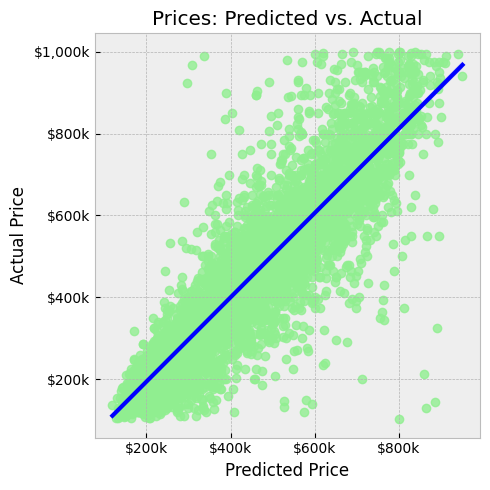

In [80]:
plt.figure(figsize=(5,5))
plt.style.use(style='bmh')

sns.regplot(data=test_data, 
            x='predicted_price', 
            y='actual_price', 
            fit_reg=True, 
            scatter_kws={'color':'lightgreen'},
            line_kws={'color':'blue'})


ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000:,.0f}k'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000:,.0f}k'))

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

plt.title('Prices: Predicted vs. Actual')

plt.tight_layout()
plt.savefig('predicted_actual.png')
plt.show()

In [57]:
test_data['pct_error'] = (test_data['predicted_price'] - test_data['actual_price']) / test_data['actual_price']

test_data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate,actual_price,predicted_price,pct_error
0,"1019 Green Pine Blvd, Apt A, West Palm Beach, ...",West Palm Beach,33409,Palm Beach,26.73,-80.11,Condo,2.00,2.00,"1,370.00",...,0,1.00,0,1.00,0,41.00,0.05,"240,000.00","265,053.84",0.10
1,"230 Nw 195th Ave, Pembroke Pines, FL 33029",Pembroke Pines,33029,Broward,26.01,-80.41,Single Family,3.00,2.00,"2,365.00",...,0,1.00,1,1.00,0,32.00,0.04,"650,000.00","782,426.25",0.20
2,"5667 Arvine Cir, Fort Myers, FL 33919",Fort Myers,33919,Lee,26.57,-81.89,Condo,3.00,2.00,"1,768.00",...,0,1.00,1,1.00,0,42.00,0.04,"550,000.00","383,700.31",-0.30
3,"6165 Carrier Dr, # 3208, Orlando, FL 32819",Orlando,32819,Orange,28.46,-81.47,Condo,1.00,1.00,408.00,...,0,1.00,0,1.00,0,39.00,0.04,"150,000.00","158,681.06",0.06
4,"12791 Sw 228th St, Miami, FL 33170",Miami,33170,Miami-Dade,25.56,-80.40,Single Family,4.00,3.00,"2,409.00",...,0,1.00,0,1.00,0,8.00,0.05,"875,000.00","712,060.81",-0.19


In [58]:
test_data['pct_error'].describe()

count   7,693.00
mean        0.04
std         0.26
min        -0.68
25%        -0.08
50%         0.00
75%         0.11
max         6.82
Name: pct_error, dtype: float64

In [59]:
test_data.groupby('propertyType')['pct_error'].mean()

propertyType
Condo           0.05
Manufactured    0.17
Single Family   0.04
Townhouse       0.08
Name: pct_error, dtype: float64

In [60]:
high_error = test_data[test_data['pct_error'] > .1]

In [61]:
high_error.groupby('propertyType')['pct_error'].mean()

propertyType
Condo           0.29
Manufactured    0.46
Single Family   0.32
Townhouse       0.32
Name: pct_error, dtype: float64

In [62]:
test_data[test_data['pct_error'] > 6]

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate,actual_price,predicted_price,pct_error
5121,"1100 State Rd, 557, Lake Alfred, FL 33850",Lake Alfred,33850,Polk,28.11,-81.73,Single Family,3.00,4.00,"3,732.00",...,1,2.00,1,1.00,0,32.00,0.04,"102,260.00","799,476.88",6.82


In [63]:
high_error.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate,actual_price,predicted_price,pct_error
0,"1019 Green Pine Blvd, Apt A, West Palm Beach, ...",West Palm Beach,33409,Palm Beach,26.73,-80.11,Condo,2.00,2.00,"1,370.00",...,0,1.00,0,1.00,0,41.00,0.05,"240,000.00","265,053.84",0.10
1,"230 Nw 195th Ave, Pembroke Pines, FL 33029",Pembroke Pines,33029,Broward,26.01,-80.41,Single Family,3.00,2.00,"2,365.00",...,0,1.00,1,1.00,0,32.00,0.04,"650,000.00","782,426.25",0.20
8,"624 Heraldo Ct, Kissimmee, FL 34758",Kissimmee,34758,Osceola,28.15,-81.46,Single Family,4.00,2.00,"2,769.00",...,0,1.00,1,1.00,0,21.00,0.04,"375,000.00","435,716.28",0.16
15,"3016 Parkway Blvd, Apt 106, Kissimmee, FL 34747",Kissimmee,34747,Osceola,28.34,-81.54,Condo,2.00,2.00,937.00,...,0,1.00,0,1.00,0,35.00,0.04,"140,000.00","220,552.83",0.58
19,"6233 Alamanda Hills Blvd, Lakeland, FL 33813",Lakeland,33813,Polk,27.95,-81.89,Single Family,4.00,3.00,"2,425.00",...,0,1.00,1,1.00,1,19.00,0.04,"399,000.00","496,279.78",0.24


In [64]:
high_error['lotSize'].describe()

count     1,997.00
mean      7,931.01
std      19,845.50
min           0.00
25%           0.00
50%       5,750.00
75%       9,583.00
max     401,125.00
Name: lotSize, dtype: float64

In [ ]:
# Saving cleaned data

conn = sqlite3.connect('/workspaces/mds8-final-project-bmh/data/raw/rentcast_FL.db')

conn.execute(""" CREATE TABLE IF NOT EXISTS properties (
             
id                  TEXT   PRIMARY KEY,
formattedAddress    TEXT,
city                TEXT,
state               TEXT,
zipCode             TEXT,
county              TEXT,
latitude            DECIMAL,
longitude           DECIMAL,
propertyType        TEXT,
bedrooms            INTEGER,
bathrooms           INTEGER,
squareFootage       INTEGER,
lotSize             INTEGER,
yearBuilt           INTEGER,
subdivision         TEXT,
zoning              TEXT,
lastSaleDate        DATETIME,
lastSalePrice       INTEGER,
hoa                 TEXT,
architectureType    TEXT,
cooling             TEXT,
coolingType         TEXT,
heating             TEXT,
heatingType         TEXT,
exteriorType        TEXT,
fireplace           TEXT,
floorCount          INTEGER,
foundationType      TEXT,
garage              TEXT,
garageSpaces        INTEGER,
garageType          TEXT,
pool                TEXT,
roomCount           INTEGER,
unitCount           INTEGER,
viewType            TEXT
);            
"""
)

data.to_sql('properties', conn, if_exists='replace', index=False)

conn.close()